<img src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/HydroSARbanner.jpg" width="100%" />

<br>
<font size="6"> <b>FIER Daily Flood Forecasting Code</b><img style="padding: 7px" src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/UAFLogo_A_647.png" width="170" align="right"/></font>

<br>
<font size="4"> <b> Franz J Meyer, University of Alaska Fairbanks</b> <br>
</font>

This notebooks is developing an algorithm to generate daily flood inundation predictions using time series of Sentinel-1 RTC data and GEOGLoWs river runoff forecasts. 
    
The workflow utilizes information available in the fierpy <a href="https://github.com/SERVIR/fierpy">fierpy</a> GitHub repository.
<hr>

# Load Python Libraries

In [1]:
from ipyfilechooser import FileChooser
import rioxarray as rxr
import xarray as xr
import fierpy
import glob
import pandas as pd
from pathlib import Path
from ipyfilechooser import FileChooser
import re
from fier_local import reof as freof
from fier_local import sel_best_fit
import opensarlab_lib as asfn
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import ipywidgets as widgets


In [2]:
def get_dates(dir_path, prefix):
    dates = []
    pths = list(dir_path.glob(f'{prefix}.tif*'))

    for p in pths:
        date_regex = '\d{8}'
        date = re.search(date_regex, str(p))
        if date:
            dates.append(date.group(0))
    return dates

**Function to grab the centerpoint coordinates of the AOI**

In [3]:
def get_centerpoint_coordinates(tif_file):
    dataset = gdal.Open(str(tif_file))
    
    # Get the geospatial transform
    geotransform = dataset.GetGeoTransform()
    
    # Get the image size
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    
    # Calculate the center pixel coordinates
    center_x = geotransform[0] + (geotransform[1] * width + geotransform[2]) / 2
    center_y = geotransform[3] + (geotransform[4] * height + geotransform[5]) / 2
    
    # Create a spatial reference object for EPSG:4326
    src_srs = osr.SpatialReference()
    src_srs.ImportFromEPSG(4326)
    
    # Create a spatial reference object for the TIF file
    dataset_srs = osr.SpatialReference()
    dataset_srs.ImportFromWkt(dataset.GetProjection())
    
    # Create a coordinate transformation object
    coord_transform = osr.CoordinateTransformation(dataset_srs, src_srs)
    
    # Transform the center point coordinates to EPSG:4326
    lon, lat, _ = coord_transform.TransformPoint(center_x, center_y)
    
    return lat, lon


**Function to calculate the fits between data, discharge and precipitations**

In [4]:
def looper(q_sel, era_sel, type_file, pola, start_ind, metricranking, score, coefficients, modes):
    
    
    if type_file == 'SAR':
        folder = 'RTC_GAMMA/'
        if pola == 'VH and VV':
            prefix = '*'
        else:
            prefix = f'*{pola}'
    else:
        folder = 'Water_Masks/'
        if pola == 'VH and VV':
            prefix = '*combined'
        else:
            prefix = f'*{pola}*'

    tiff_dir = Path(fc.selected)/folder
    tiffs = list(tiff_dir.glob(f'{prefix}.tif*'))
    
    times = get_dates(tiff_dir, prefix)
    times.sort()
    times = pd.DatetimeIndex(times)
    times.name = "time"
    
    da = xr.concat([rxr.open_rasterio(f) for f in tiffs], dim=times)

    # delete the extra data variable 'band'
    da = da.sel(band=1, drop=True)
    # rename autogenerated x,y as lon,lat 
    da = da.rename({'x': 'lon', 'y': 'lat'}).fillna(0)
    
    # Calculate the REOF of the dataset
    reof_ds = freof(da[:start_ind], n_modes = 4)

    #### Discharge Fit
    # Calculate the fits of different polynomials concerning each main mode
    fits = fierpy.find_fits(reof_ds.fillna(0),q_sel,da[:start_ind])
    # Grab the best fitting mode and coefficients
    name,mode,coeffs = sel_best_fit(fits, metricranking[0], metricranking[1])
    
    if metricranking[0] == 'r2':
        suffix = 'fit'
    else:
        suffix = 'pred'
        
    # Put score of this coeff in the score list
    score[0].append(fits[f"{'_'.join(name.split('_')[:2])}_{suffix}_{metricranking[0]}"])   
    coefficients[0].append(coeffs)
    modes[0].append(mode)
    
    #### ERA Fit
    # Calculate the fits of different polynomials concerning each main mode
    fits = fierpy.find_fits(reof_ds.fillna(0),era_sel,da[:start_ind])
    # Grab the best fitting mode and coefficients
    name,mode,coeffs = sel_best_fit(fits, metricranking[0], metricranking[1])
    
    if metricranking[0] == 'r2':
        suffix = 'fit'
    else:
        suffix = 'pred'
        
    # Put score of this coeff in the score list
    score[1].append(fits[f"{'_'.join(name.split('_')[:2])}_{suffix}_{metricranking[0]}"])   
    coefficients[1].append(coeffs)
    modes[1].append(mode)
    
    
    return reof_ds, da, coefficients, modes, score

<hr>

# Choose the folder of the area you want to work with (subfolder of "Dataset")

In [5]:
fc = FileChooser(Path.cwd())
display(fc)

FileChooser(path='/home/jovyan/Hydrosar', filename='', title='', show_hidden=False, select_desc='Select', chan…

#### **Instructions**

**1 - Generate the flood percentage figure**  

**2 - Select a date range (format 'YYYY-MM-DD')**

**2 - Choose the criteria on which you want to base the best fit selection (rmse, r2, r).**

- Choose between "rmse", "r", "r2"
- If you choose "r2", you have to write "max"
- "min" otherwise


Text(0.5, 1.0, 'Maximum water coverage on 2019-07-27, index: 67')

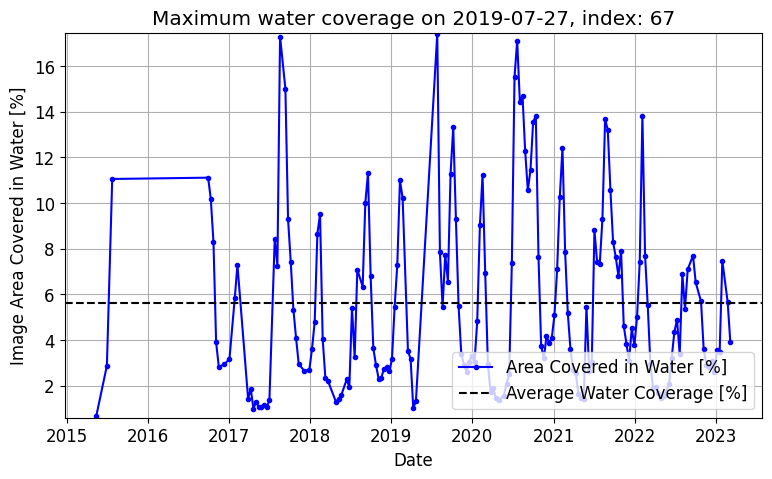

In [6]:
# List of available dataset
list_types = ['SAR','Water Mask']
# List of available polarizations
list_polarization = ['VH', 'VH and VV', 'VV']

# Create the folder for the figures
pathfig = Path(fc.selected)/'Figures'
pathfig.mkdir(exist_ok=True)

# Prepare the list of coefficients, modes and scores to be updated on each iteration
coefficients = [[],[]]
modes = [[],[]]
score = [[],[]]


# Load the time template, every file combination has the same
tiff_dir = Path(fc.selected)/'RTC_GAMMA'
tiffs = list(tiff_dir.glob(f'*VV.tif*'))

times = get_dates(tiff_dir, '*VV')
times.sort()
times = pd.DatetimeIndex(times)
times.name = "time"


pathfig = Path(fc.selected)/'Figures'

floodpercent = np.load(pathfig/"flood_percentage.npy")
time_index = np.load(pathfig/"time_index.npy")
time_index = pd.DatetimeIndex(time_index)
plt.rcParams.update({'font.size': 12})


fig, ax = plt.subplots(figsize=(9,5))

ax.plot(np.unique(time_index), floodpercent, color='b', marker='o', markersize=3, label='Area Covered in Water [%]')
ax.set_ylim([np.min(floodpercent)-np.min(floodpercent)*0.1, np.max(floodpercent)+np.min(floodpercent)*0.1])
ax.set_xlabel('Date')
ax.axhline(y=np.mean(floodpercent), color='k', linestyle='--', label='Average Water Coverage [%]')
ax.set_ylabel('Image Area Covered in Water [%]')
ax.grid()
figname = ('ThresholdAndAreaTS.png')
ax.legend(loc='lower right')
plt.title(f"Maximum water coverage on {time_index[np.argmax(floodpercent)].strftime('%Y-%m-%d')}, index: {np.argmax(floodpercent)}")


**Choose the time window for the forecast**
Choose either a date range, or the index of the event you want to test.

In [7]:
#sdate = '2019-07-01'
#edate = '2020-08-15'
sdate = 67
edate = 68

metricranking = ('r2','max')

if type(sdate) is int:
    start_ind = sdate
    stop_ind = edate
else:
    start_ind = np.argmin(np.abs(times-pd.to_datetime(sdate)))
    stop_ind = np.argmin(np.abs(times-pd.to_datetime(edate)))

if start_ind == stop_ind or start_ind > stop_ind:
    print('Please select other dates')

**Run the fit calculation for every polarization and dataset type available. This will help choosing which of water masks or SAR, VV/VH/VV&VH is the best combination**

In [ ]:
# Convert 'times' to a dataarray to use with match_dates()
time_dataarray = xr.DataArray(np.array(times), dims='time', coords={'time': np.array(times)})

# Load in memory the discharge  dataset (will be the same everytime)
lon,lat = get_centerpoint_coordinates(tiffs[0])
q = fierpy.get_streamflow(lat,lon)
q_sel = fierpy.match_dates(q[0], time_dataarray[:start_ind])


# Get the projection of the AOI
info = gdal.Info(str(tiffs[0]), format='json')
info = info['coordinateSystem']['wkt']
utm = info.split('ID')[-1].split(',')[1][0:-2]

# Get the bounds of the AOI
dataset = gdal.Open(str(tiffs[0]))
if dataset is not None:
    # Get the transformation information
    transform = dataset.GetGeoTransform()

    # Extract the corner coordinates
    xmin = transform[0]
    ymax = transform[3]
    xmax = xmin + transform[1] * dataset.RasterXSize
    ymin = ymax + transform[5] * dataset.RasterYSize

from pyproj import Transformer
points = [(ymin, xmin), (ymax, xmax)]  
boundaries = []
transformer = Transformer.from_crs(int(utm), 4326)
for pt in transformer.itransform(points): boundaries.append(pt)
boundaries = np.array(boundaries)

# Open Dataarray
era_ds = xr.open_dataarray(f"{Path(fc.selected).parent}/ERA5/era5_data.nc")

# Get the closest lats and lons from the AOI's boundaries, otherwise slicing the dataset can return empty slices
latmin = era_ds['latitude'].values[np.argmin(np.abs(era_ds['latitude'].values - boundaries[0][0]))]
latmax = era_ds['latitude'].values[np.argmin(np.abs(era_ds['latitude'].values - boundaries[1][0]))]
lonmin = era_ds['longitude'].values[np.argmin(np.abs(era_ds['longitude'].values - boundaries[0][1]))]
lonmax = era_ds['longitude'].values[np.argmin(np.abs(era_ds['longitude'].values - boundaries[1][1]))]

# Load in memory the precipitation dataset, fitted to the AOI, as a dataarray so it can use the match_dates function
era_ds = era_ds.sel(longitude = slice(lonmin, lonmax), latitude = slice(latmax, latmin))
# Convert to dataarray
era_ds = xr.DataArray(np.sum(np.sum(era_ds.values,axis=1),axis=1), dims='time', coords={'time': era_ds.time.values})
# Select the data corresponding to time
era_sel = fierpy.match_dates(era_ds, time_dataarray[:start_ind]).fillna(0)


# Iterate through every dataset type and polarization to compute the fits with the discharge
c = 1
for filetype in list_types:
    for polarization in list_polarization:
        print(f"Starting {filetype} {polarization}")
        # There is no VH&VV polarization for SAR so we skip the fitting
        if filetype == 'SAR' and polarization == 'VH and VV':
            coefficients[0].append(np.array([0,0,0]))
            modes[0].append(0)
            coefficients[1].append(np.array([0,0,0]))
            modes[1].append(0)
            
            # Depending on the metric and ranking we want to make sure the fake score is the worst
            if metricranking[1] == 'min':
                score[0].append(1e9)
                score[1].append(1e9)
            else:
                score[0].append(-1e9)
                score[1].append(-1e9)
        else:
            reof_ds, da, coefficients, modes, score = looper(q_sel, era_sel, filetype,
                                            polarization,
                                            start_ind,
                                            metricranking,
                                            score,
                                            coefficients,
                                            modes)
        print(f"{c}/{len(list_types) + len(list_polarization)} | Finished computing {filetype} {polarization}")
        c += 1

/home/jovyan/.local/envs/hydrosar/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning:

Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.



Starting SAR VH
(67, 4)
1/5 | Finished computing SAR VH
Starting SAR VH and VV
2/12 | Finished computing SAR VH and VV
Starting SAR VV
(67, 4)


**Select the best mode and associated coefficients based on the ranking score**

In [ ]:
if metricranking[1] == 'min':
    best_score_index_q = score[0].index(min(score[0]))
    best_score_index_era = score[1].index(min(score[1]))
else:
    best_score_index_q = score[0].index(max(score[0]))
    best_score_index_era = score[1].index(max(score[1]))
    
if best_score_index_q < 3:
    filetype_q = 'SAR'
    polarization_q = list_polarization[best_score_index_q]
else:
    filetype_q = 'Water_Mask'
    polarization_q = list_polarization[best_score_index_q-3]
    
if best_score_index_era < 3:
    filetype_era = 'SAR'
    polarization_era = list_polarization[best_score_index_era]
else:
    filetype_era = 'Water_Mask'
    polarization_era = list_polarization[best_score_index_era-3]

coeffs_q = np.array(coefficients[0][best_score_index_q])
mode_q = modes[0][best_score_index_q] 
coeffs_era = np.array(coefficients[1][best_score_index_era])
mode_era = modes[1][best_score_index_era]

    
##### FOR Q
# Compute the reof and datacube of the best fitting dataset/polarization    
reof_ds_q, da_q, *_ = looper(q_sel, era_sel, filetype_q, polarization_q, start_ind, metricranking, score, coefficients, modes)
da_comp_q = da_q[start_ind:stop_ind+1]

##### FOR ERA
reof_ds_era, da_era, *_ = looper(q_sel, era_sel, filetype_era, polarization_era, start_ind, metricranking, score, coefficients, modes)
da_comp_era = da_era[start_ind:stop_ind+1]



**Prepare the datasets for the fit**

In [ ]:
# We fill in the NaNs to avoid breaking the fit
reof_ds_q.spatial_modes.values[reof_ds_q.spatial_modes.values==0]=np.nan
reof_ds_era.spatial_modes.values[reof_ds_era.spatial_modes.values==0]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(20,5), ncols=2)
x = np.linspace(0, q_sel.max(),100)
f = np.poly1d(np.squeeze(coeffs_q))
ax[0].plot(q_sel, reof_ds_q.temporal_modes[:,mode_q-1], 'o', label=f"{metricranking[0]} = {np.round(score[0][best_score_index_q],5)}")
ax[0].legend()
ax[0].set_xlabel('Discharge [$m^{3}.s^{-1}$]')
ax[0].set_ylabel('Time series amplitude')
ax[0].plot(x,f(x))
ax[0].set_title(f"Fit for mode {mode_q}, poly degree {len(coeffs_q)-1}, {filetype_q}_{polarization_q}")

                 

x = np.linspace(0, era_sel.max(),100)
f = np.poly1d(np.squeeze(coeffs_era))
ax[1].plot(era_sel, reof_ds_era.temporal_modes[:,mode_era-1], 'o',  label=f"{metricranking[0]} = {np.round(score[1][best_score_index_era], 5)}")
ax[1].legend()
ax[1].set_xlabel('Precipitations [m]')
ax[1].set_ylabel('Time series amplitude')
ax[1].plot(x,f(x))
ax[1].set_title(f"Fit for mode {mode_era}, poly degree {len(coeffs_era)-1}, {filetype_era}_{polarization_era}")                 
plt.savefig(pathfig/'Modes_Fit.png')

**Plot the spatiotemporal modes for the discharge** 

In [ ]:
# Open figure based on amount of modes
plt.figure()
num_columns = len(reof_ds_q.mode.values)  # Number of columns in your subplots
width_per_subplot = 5  # Desired width (in inches) for each subplot

fig_width = num_columns * width_per_subplot

fig, axes = plt.subplots(nrows=2, ncols=num_columns, figsize=(fig_width, 10))
fig.suptitle(f"Modes from {times[0].strftime('%Y-%m-%d')} to {times[start_ind].strftime('%Y-%m-%d')}, {filetype_q} {polarization_q}", fontsize=22)
# This part plots the spatial modes
for i, ax in enumerate(axes[0]):

    # Create a plot of the spatial modes
    mesh = ax.imshow(reof_ds_q.spatial_modes.values[:,:,i],
              cmap = 'icefire',
              vmin = -np.nanstd(reof_ds_q.spatial_modes.values[:,:,i])/2+np.nanmean(reof_ds_q.spatial_modes.values[:,:,i]),
              vmax = np.nanstd(reof_ds_q.spatial_modes.values[:,:,i])/2+np.nanmean(reof_ds_q.spatial_modes.values[:,:,i]))

    # Set plot title and labels
    ax.set_title(f"Spatial Mode {i}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
                      
    # Add colorbar
    cbar = fig.colorbar(mesh, ax=ax)

# This part plots the temporal modes with the discharge superimposed
for i, ax in enumerate(axes[1]):
    # Create a line plot of the temporal mode
    ax.scatter(times[:start_ind], reof_ds_q.temporal_modes[:, i], color = 'red', label='Temporal Modes', s = 150)
    # Format x-tick labels as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
    # Rotate x-tick labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    # Set plot title and labels
    ax.set_title(f"Temporal Mode {i}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

    # Create a secondary y-axis on the right
    ax_secondary = ax.twinx()

    # Plot the secondary data as bars on the right axis
    ax_secondary.bar(times[:start_ind], q_sel.values, color='blue', alpha=0.5, label = 'Discharge')
    ax_secondary.set_ylabel('GeoGLOWS Discharge [$m^{3}.s^{-1}$]')


plt.savefig(pathfig/f"SpatiotempModes_Discharge_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}_{filetype_q}_{polarization_q}.png", dpi = 400)
plt.tight_layout()
plt.show()

In [ ]:
# Open figure based on amount of modes
plt.figure()

num_columns = len(reof_ds_era.mode.values)  # Number of columns in your subplots
width_per_subplot = 5  # Desired width (in inches) for each subplot

fig_width = num_columns * width_per_subplot

fig, axes = plt.subplots(nrows=2, ncols=num_columns, figsize=(fig_width, 10))
fig.suptitle(f"Modes from {times[0].strftime('%Y-%m-%d')} to {times[start_ind].strftime('%Y-%m-%d')}, {filetype_era} {polarization_era}", fontsize=22)

# This part plots the spatial modes
for i, ax in enumerate(axes[0]):

    # Create a plot of the spatial modes
    mesh = ax.imshow(reof_ds_era.spatial_modes.values[:,:,i],
              cmap = 'icefire',
              vmin = -np.nanstd(reof_ds_era.spatial_modes.values[:,:,i])/2+np.nanmean(reof_ds_era.spatial_modes.values[:,:,i]),
              vmax = np.nanstd(reof_ds_era.spatial_modes.values[:,:,i])/2+np.nanmean(reof_ds_era.spatial_modes.values[:,:,i]))

    # Set plot title and labels
    ax.set_title(f"Spatial Mode {i+1}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
                      
    # Add colorbar
    cbar = fig.colorbar(mesh, ax=ax)

# This part plots the temporal modes with the discharge superimposed
for i, ax in enumerate(axes[1]):
    # Create a line plot of the temporal mode
    ax.scatter(times[:start_ind], reof_ds_era.temporal_modes[:, i], color = 'red', label='Temporal Modes', s = 150)
    # Format x-tick labels as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
    # Rotate x-tick labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    # Set plot title and labels
    ax.set_title(f"Temporal Mode {i + 1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

    # Create a secondary y-axis on the right
    ax_secondary = ax.twinx()

    # Plot the secondary data as bars on the right axis
    ax_secondary.bar(times[:start_ind], era_sel.values, color='blue', alpha=0.5, label = 'Precipitations')
    ax_secondary.set_ylabel('ERA5 Precipitation [$mm.yr^{-1}$]')


plt.savefig(pathfig/f"SpatiotempModes_Precipitation_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}_{filetype_era}_{polarization_era}.png", dpi = 400)
plt.tight_layout()
plt.show()

<hr>

#### **Calculate the forecast of flooding based on the relationship between discharge and the main modes of our dataset**

**Calculate the amount of days between sdate and edate**

In [ ]:
# Amount of days for the forecast
nb_days_forecast = (times[stop_ind] - times[start_ind]).days

**Generate the forecast based on the best fit coefficients**

In [ ]:
# Generate new dates array nb_days_forecast days into the future and save them as a dataset
forecast_dates = xr.Dataset.from_dataframe(
                    pd.DataFrame(
                        {'time': da[:start_ind+1].time.max().values +
                         np.arange(1, nb_days_forecast, dtype='timedelta64[D]')}
                    )
                    )

# Grab the GeoGLOWS forecast
q_forecast = fierpy.match_dates(q[0],forecast_dates)
# Grab the precipitation forecast
era_forecast = fierpy.match_dates(era_ds,forecast_dates)

# Use the previously found relationships and functions to generate RTC/mask forecast
forecast_q = fierpy.synthesize(reof_ds_q, q_forecast, np.poly1d(coeffs_q), mode_q)
forecast_era = fierpy.synthesize(reof_ds_era, era_forecast, np.poly1d(coeffs_era), mode_era)


**Grab overlapping dates between forecast and dataset to compare the forecast quality**

In [ ]:
# Get the matching indices
ind_precast = np.where(np.isin(da_comp_q['time'].values,forecast_q['time'].values))[0]
ind_forecast = np.where(np.isin(forecast_q['time'].values,da_comp_q['time'].values))[0]

# Grab the slices of the datasets corresponding to the matching indices
forecast_slice_q = forecast_q.isel(time=ind_forecast)
forecast_slice_era = forecast_era.isel(time=ind_forecast)
da_slice_q = da_comp_q.isel(time=ind_precast)
da_slice_era = da_comp_era.isel(time=ind_precast)


# Calculate the difference between the slices
difference_q = forecast_slice_q - da_slice_q
difference_era = forecast_slice_era - da_slice_era


**Plot the forecasts and their associated real data to compare spatial correspondance**
*The colorbar is adjusted to the values of each normalized dataset. We use as colorbar boundaries:
$\mu(\text{dataset})\pm\sigma(\text{dataset})$*

In [ ]:
# Automatically set the size of the plot
num_columns = len(forecast_slice_q.time)  # Number of columns in your subplots
width_per_subplot = 5  # Desired width (in inches) for each subplot
fig_width = num_columns * width_per_subplot

# Start Figure
fig, ax = plt.subplots(figsize=(fig_width, 15), nrows = 4, ncols = num_columns)

# Fill NaNs with 0s
forecast_slice_q_nonan = forecast_slice_q.fillna(0)
forecast_slice_era_nonan = forecast_slice_era.fillna(0)
# Create title
fig.suptitle(f"Q: {filetype_q} {polarization_q}, mode {mode_q}, poly deg {len(coeffs_q)-1} | Prec: {filetype_era} {polarization_era}, mode {mode_era}, poly deg{len(coeffs_era)-1}", fontsize = 20)

# Loop to plot the data. We use the forecast and their associated real data, normalized
# The colorbar is varying from -std+mean to std+mean
for i in range(da_slice_q.time.shape[0]):
    nda = (da_slice_q[i]-da_slice_q[i].min())/(da_slice_q[i].max()-da_slice_q[i].min())
    nda_era = (da_slice_era[i]-da_slice_era[i].min())/(da_slice_era[i].max()-da_slice_era[i].min())
    ndq = (forecast_slice_q_nonan[i]-forecast_slice_q_nonan[i].min())/(forecast_slice_q_nonan[i].max()-forecast_slice_q_nonan[i].min())
    ndera = (forecast_slice_era_nonan[i]-forecast_slice_era_nonan[i].min())/(forecast_slice_era_nonan[i].max()-forecast_slice_era_nonan[i].min())
    ax[0,i].imshow(nda, vmin = -nda.std() + nda.mean(), vmax = nda.std() + nda.mean())
    ax[0,i].set_title(f"{str(da_slice_q[i].time.values)[0:10]}, f{ind_forecast[i]}", fontsize = 17)
    ax[1,i].imshow(ndq, vmin = -ndq.std() + ndq.mean(), vmax = ndq.std() + ndq.mean())
    ax[2,i].imshow(nda_era, vmin = -nda_era.std() + nda_era.mean(), vmax = nda_era.std() + nda_era.mean())
    ax[3,i].imshow(ndera, vmin = -ndera.std() + ndera.mean(), vmax = ndera.std() + ndera.mean())
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[2,i].set_xticks([])
    ax[2,i].set_yticks([])   
    ax[3,i].set_xticks([])
    ax[3,i].set_yticks([])
    
# Some axis labels
ax[0,0].set_ylabel(f'Real {filetype_q} {polarization_q}', fontsize = 15)
ax[1,0].set_ylabel(f'Forecast {filetype_q} {polarization_q}', fontsize = 15)
ax[2,0].set_ylabel(f'Real {filetype_era} {polarization_era}', fontsize = 15)
ax[3,0].set_ylabel(f'Forecast {filetype_era} {polarization_era}', fontsize = 15)

# rearange the axes for no overlap
fig.tight_layout()

# Plot line in the middle
line = plt.Line2D([0,1],[0.48,0.48], transform=fig.transFigure, color="red")
# Create the first title for the first two rows
title1 = fig.text(0.01, 0.75, 'Discharge', va='center', ha='center', rotation='vertical', color='red', fontsize = 20)

# Create the second title for the last two rows
title2 = fig.text(0.01, 0.25, 'Precipitations', va='center', ha='center', rotation='vertical', color='red', fontsize = 20)

fig.add_artist(line)


plt.savefig(pathfig/f"Data_Forecast_Discharge.png")

**Calculate the principal modes (REOFs) of the forecast and real data to compare them**




In [ ]:
# Calculate Reofs forecasts and their real equivalents
reof_da_slice_q = freof(da_slice_q, n_modes = da_slice_q.shape[0])
reof_da_slice_era= freof(da_slice_era, n_modes = da_slice_era.shape[0])
reof_forecast_slice_q = freof(forecast_slice_q_nonan, n_modes = forecast_slice_q_nonan.shape[0])
reof_forecast_slice_era = freof(forecast_slice_era_nonan, n_modes = forecast_slice_era_nonan.shape[0])

**Normalize the REOFs for comparison**

In [ ]:
# Normalize the datasets
# Define the normalization function
def normalize_slice(arr):
    # Calculate the maximum value in the slice
    max_val = np.max(arr)
    min_val = np.min(arr)
    # Normalize the slice by dividing each element by the maximum value
    normalized_arr = (arr - min_val)/(max_val - min_val)
    return normalized_arr

# Apply the normalization function to each slice of the variable
spatial_q = xr.apply_ufunc(normalize_slice, reof_da_slice_q.spatial_modes)
spatial_forecast_q = xr.apply_ufunc(normalize_slice, reof_forecast_slice_q.spatial_modes)
spatial_era = xr.apply_ufunc(normalize_slice, reof_da_slice_era.spatial_modes)
spatial_forecast_era = xr.apply_ufunc(normalize_slice, reof_forecast_slice_era.spatial_modes)

spatial_diff_q = spatial_forecast_q - spatial_q
spatial_diff_era = spatial_forecast_era - spatial_era

temp_q = (reof_da_slice_q.temporal_modes - reof_da_slice_q.temporal_modes.min()) / (reof_da_slice_q.temporal_modes.max() - reof_da_slice_q.temporal_modes.min())
temp_era = (reof_da_slice_era.temporal_modes - reof_da_slice_era.temporal_modes.min()) / (reof_da_slice_era.temporal_modes.max() - reof_da_slice_era.temporal_modes.min())
temp_forecast_q = (reof_forecast_slice_q.temporal_modes - reof_forecast_slice_q.temporal_modes.min()) / (reof_forecast_slice_q.temporal_modes.max() - reof_forecast_slice_q.temporal_modes.min())
temp_forecast_era = (reof_forecast_slice_era.temporal_modes - reof_forecast_slice_era.temporal_modes.min()) / (reof_forecast_slice_era.temporal_modes.max() - reof_forecast_slice_era.temporal_modes.min())

temp_diff_q = temp_forecast_q - temp_q
temp_diff_era = temp_forecast_era - temp_era



**Plot the differences between the REOFs of forecasts and real data**

We use as colorbar boundaries:
$\mu(\text{dataset})\pm\sigma(\text{dataset})$

In [ ]:
# Open figure based on amount of modes
plt.figure()

num_columns = len(reof_da_slice_q.mode.values)  # Number of columns in your subplots
width_per_subplot = 5  # Desired width (in inches) for each subplot

fig_width = num_columns * width_per_subplot

fig, axes = plt.subplots(nrows=2, ncols=num_columns, figsize=(fig_width, 10))
fig.suptitle(f"Q: Difference forecast/data modes from {times[0].strftime('%Y-%m-%d')} to {times[start_ind].strftime('%Y-%m-%d')}, {filetype_era} {polarization_era}", fontsize=22)

# This part plots the spatial modes
for i, ax in enumerate(axes[0]):

    # Create a plot of the spatial modes
    mesh = ax.imshow(spatial_diff_q.values[:,:,i],
              cmap = 'icefire',
              vmin = -np.nanstd(spatial_diff_q.values[:,:,i])+np.nanmean(spatial_diff_q.values[:,:,i]),
              vmax = np.nanstd(spatial_diff_q.values[:,:,i])+np.nanmean(spatial_diff_q.values[:,:,i]))

    # Set plot title and labels
    ax.set_title(f"Spatial Mode {i+1}")

                      
    # Add colorbar
    cbar = fig.colorbar(mesh, ax=ax)

# This part plots the temporal modes with the discharge superimposed
for i, ax in enumerate(axes[1]):
    # Create a line plot of the temporal mode
    ax.scatter(times[ind_forecast], temp_diff_q[:, i], color = 'red', label='Temporal Modes', s = 150)
    # Format x-tick labels as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
    # Rotate x-tick labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    # Set plot title and labels
    ax.set_title(f"Temporal Mode {i + 1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

plt.savefig(pathfig/f"Forecast_data_diff_discharge_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}_{filetype_era}_{polarization_era}.png", dpi = 400)
plt.tight_layout()
plt.show()

In [ ]:
# Open figure based on amount of modes
plt.figure()
num_columns = len(reof_da_slice_q.mode.values)  # Number of columns in your subplots
width_per_subplot = 5  # Desired width (in inches) for each subplot

fig_width = num_columns * width_per_subplot

fig, axes = plt.subplots(nrows=2, ncols=num_columns, figsize=(fig_width, 10))
fig.suptitle(f"Prec: Difference forecast/data modes from {times[0].strftime('%Y-%m-%d')} to {times[start_ind].strftime('%Y-%m-%d')}, {filetype_era} {polarization_era}", fontsize=22)

# This part plots the spatial modes
for i, ax in enumerate(axes[0]):

    # Create a plot of the spatial modes
    mesh = ax.imshow(spatial_diff_era.values[:,:,i],
              cmap = 'icefire',
              vmin = -np.nanstd(spatial_diff_era.values[:,:,i])+np.nanmean(spatial_diff_era.values[:,:,i]),
              vmax = np.nanstd(spatial_diff_era.values[:,:,i])+np.nanmean(spatial_diff_era.values[:,:,i]))

    # Set plot title and labels
    ax.set_title(f"Spatial Mode {i}")

                      
    # Add colorbar
    cbar = fig.colorbar(mesh, ax=ax)

# This part plots the temporal modes with the discharge superimposed
for i, ax in enumerate(axes[1]):
    # Create a line plot of the temporal mode
    ax.scatter(times[ind_forecast], temp_diff_era[:, i], color = 'red', label='Temporal Modes', s = 150)
    # Format x-tick labels as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
    # Rotate x-tick labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    # Set plot title and labels
    ax.set_title(f"Temporal Mode {i + 1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

plt.savefig(pathfig/f"Forecast_data_diff_prec_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}_{filetype_era}_{polarization_era}.png", dpi = 400)
plt.tight_layout()
plt.show()

**Calculate some statistics**

In [ ]:
from scipy.stats import ttest_ind
# Calculate means
mean_forecast = np.nanmean(forecast_slice_q.values)
mean_da_comp = np.nanmean(da_slice_q.values)

# Calculate the average of the differences in percentage of the real RTCs
mean_diff_q = np.nanmean((difference_q.values*100)/da_slice_q.values)


# Calculate standard deviations
std_forecast = np.nanstd(forecast_slice_q.values)
std_da_comp = np.nanstd(da_slice_q.values)

# Calculate correlation coefficient
valid_mask = np.isfinite(forecast_slice_q.values) & np.isfinite(da_slice_q.values)
correlation = np.corrcoef(forecast_slice_q.values[valid_mask], da_slice_q.values[valid_mask])[0, 1]

# Calculate quantiles
quantiles_forecast = np.percentile(forecast_slice_q.fillna(0), [25, 50, 75])
quantiles_da_comp = np.percentile(da_slice_q.fillna(0), [25, 50, 75])

# Perform t-test
t_stat, p_value = ttest_ind(forecast_slice_q.fillna(0).values.flatten(), da_slice_q.fillna(0).values.flatten())

# Print results
print("Mean of forecast_slice:", mean_forecast)
print("Mean of da_slice:", mean_da_comp)
print("Mean difference discharge in percentage of the real dataset:", mean_diff_q)
print("Standard Deviation of forecast_slice:", std_forecast)
print("Standard Deviation of da_slice:", std_da_comp)
print("Correlation coefficient between forecast_slice and da_slice:", correlation)
print("Quantiles of forecast_slice:", quantiles_forecast)
print("Quantiles of da_slice:", quantiles_da_comp)
print("T-statistic:", t_stat)
print("P-value:", p_value)


In [ ]:
from scipy.stats import ttest_ind
# Calculate means
mean_forecast = np.nanmean(forecast_slice_era.values)
mean_da_comp = np.nanmean(da_slice_era.values)

# Calculate the average of the differences in percentage of the real RTCs
mean_diff_era = np.nanmean((difference_era.values*100)/da_slice_era.values)

# Calculate standard deviations
std_forecast = np.nanstd(forecast_slice_era.values)
std_da_comp = np.nanstd(da_slice_era.values)

# Calculate correlation coefficient
valid_mask = np.isfinite(forecast_slice_era.values) & np.isfinite(da_slice_era.values)
correlation = np.corrcoef(forecast_slice_era.values[valid_mask], da_slice_era.values[valid_mask])[0, 1]

# Calculate quantiles
quantiles_forecast = np.percentile(forecast_slice_era.fillna(0), [25, 50, 75])
quantiles_da_comp = np.percentile(da_slice_era.fillna(0), [25, 50, 75])

# Perform t-test
t_stat, p_value = ttest_ind(forecast_slice_era.fillna(0).values.flatten(), da_slice_era.fillna(0).values.flatten())

# Print results
print("Mean of forecast_slice:", mean_forecast)
print("Mean of da_slice:", mean_da_comp)
print("Mean difference precipitation in percentage of the real dataset:", mean_diff_era)
print("Standard Deviation of forecast_slice:", std_forecast)
print("Standard Deviation of da_slice:", std_da_comp)
print("Correlation coefficient between forecast_slice and da_slice:", correlation)
print("Quantiles of forecast_slice:", quantiles_forecast)
print("Quantiles of da_slice:", quantiles_da_comp)
print("T-statistic:", t_stat)
print("P-value:", p_value)

**Plot a histogram of the differences values**

In [ ]:
# Plot the histogram of values
plt.hist(np.nanmean(spatial_diff_q.values, axis = 0), bins=10)  # Adjust the number of bins as needed
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Q: Diff Normalized Forecast modes - Data modes')
plt.legend([f"Mode {i+1}" for i in range(spatial_diff_q.shape[2])])
plt.show()
plt.savefig(pathfig/f"Histogram_difference_Discharge_{times[start_ind:stop_ind][ind_precast][0].strftime('%Y-%m-%d')}_{times[start_ind:stop_ind][ind_precast][-1].strftime('%Y-%m-%d')}_{filetype_q}_{polarization_q}.png", dpi = 400)


In [ ]:
# Plot the histogram of values
plt.hist(np.nanmean(spatial_diff_era.values, axis = 0), bins=10)  # Adjust the number of bins as needed
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Prec: Diff Normalized Forecast modes - Data modes')
plt.legend([f"Mode {i+1}" for i in range(spatial_diff_era.shape[2])])
plt.show()
plt.savefig(pathfig/f"Histogram_difference_Prec_{times[start_ind:stop_ind][ind_precast][0].strftime('%Y-%m-%d')}_{times[start_ind:stop_ind][ind_precast][-1].strftime('%Y-%m-%d')}_{filetype_q}_{polarization_q}.png", dpi = 400)


In [ ]:
fro_q= np.linalg.norm(spatial_diff_q, axis=2)
fro_era= np.linalg.norm(spatial_diff_era, axis=2)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)

# Plot the first matrix with colorbar and title
im0 = ax[0].imshow(fro_q, vmin=-np.std(fro_q) + np.mean(fro_q), vmax=np.std(fro_q) + np.mean(fro_q))
cbar0 = fig.colorbar(im0, ax=ax[0], shrink=1.0)
cbar0.set_label('Frobenius norm value')

ax[0].set_title('Discharge difference')

# Plot the second matrix with colorbar and title
im1 = ax[1].imshow(fro_era, vmin=-np.std(fro_era) + np.mean(fro_era), vmax=np.std(fro_era) + np.mean(fro_era))
cbar1 = fig.colorbar(im1, ax=ax[1], shrink=1.0)
cbar1.set_label('Frobenius norm value')

ax[1].set_title('Precipitation difference')

# Set the title for the entire figure
fig.suptitle('Frobenius norm of spatial modes difference between forecast and real data')

plt.show()
plt.savefig(pathfig/f"Frobenius_{times[start_ind:stop_ind][ind_precast][0].strftime('%Y-%m-%d')}_{times[start_ind:stop_ind][ind_precast][-1].strftime('%Y-%m-%d')}_{filetype_q}_{polarization_q}.png", dpi = 400)
